#Detecting the difficulty level of French texts

Given a text in French, can you predict its difficulty level (A1, A2, B1, B2, C1, C2)?

# 1- Environnement Settings#

###IMPORTS
---------------------------------------------------------------------------------------------

In [ ]:
!pip install -U spacy

!python ourfunctions.py

from ourfunctions import *

import string

import os
import sys

import pandas as pd
import numpy as np
import numpy
import csv
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#Logistic regression Import

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

#KNN IMPORT

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import spacy as spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc

from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from gensim.models import word2vec

import nltk as nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk import word_tokenize

import re
#PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

#Confusion Matrix 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#Bert model
from sklearn.preprocessing import LabelEncoder

from nltk.stem import WordNetLemmatizer

from IPython.display import YouTubeVideo


np.random.seed = 0

In [3]:
# Download the French language model
!python -m spacy download fr


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-22 10:41:38.702817: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'fr' are deprecated. Please use the
full pipeline package name 'fr_core_news_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 281 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [4]:

# Load French language model:
sp = spacy.load('fr_core_news_sm')

#2- DataFrames Settings 
--------------------------------------

1- df_training represente the dataframe containg the training set on which we wil test the models.

In [5]:
#1

training_data = 'https://raw.githubusercontent.com/mireille07/UNIL_Lausanne/main/Data/training_data.csv'

df_training  = pd.read_csv(training_data, encoding='utf-8')

In [ ]:
df_training.head(1)

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1


In [6]:
#2

unlabelled_test_data= 'https://raw.githubusercontent.com/mireille07/UNIL_Lausanne/main/Data/unlabelled_test_data.csv'

df_pred = pd.read_csv(unlabelled_test_data, encoding='utf-8')

In [7]:
#3

sample_submission = ('https://raw.githubusercontent.com/mireille07/UNIL_Lausanne/main/Data/sample_submission.csv')

df_pred = pd.read_csv(sample_submission, encoding='utf-8')


#Part 1 : Models without Cleaning 
-------------------------------------------------

-----------------------------------

In [10]:
df_1= df_training.copy()

In [8]:
result = [] # This list will hold all the results that we wwill get from our trained models without cleaning data

result_c = [] # With cleaned data




In [11]:
#BaseRate

base_rate = np.max(df_1.difficulty.value_counts()/df_1.difficulty.shape[0]) 
# Good if the base rate is arount 0.5
print(f"Base rate:\n{base_rate:.4f}")

Base rate:
0.1694


In [ ]:
df_1['difficulty'].value_counts()

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

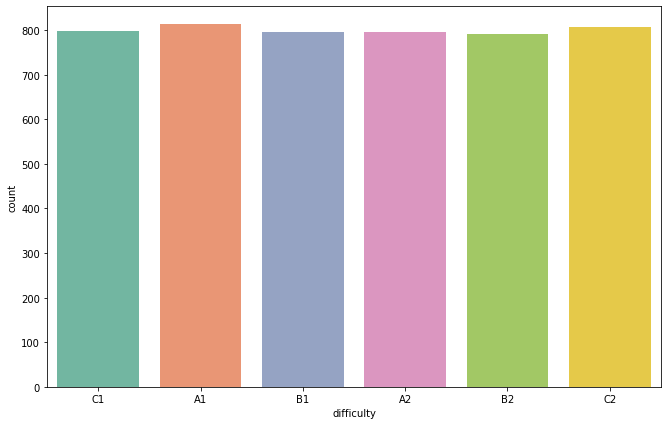

In [12]:

plt.figure(figsize=(11,7))
sns.countplot(x=df_1.difficulty, palette = "Set2")
plt.show()

 ### Use OrdinalEncoder to encode the "difficulty column"#

In [ ]:
df_1['difficulty']

0       C1
1       A1
2       A1
3       A1
4       B1
        ..
4795    B2
4796    C1
4797    A2
4798    C2
4799    C2
Name: difficulty, Length: 4800, dtype: object

#Functions#

In [13]:
%%writefile ourfunctions.py

#Evaluate fonction

def evaluate(true, pred):
      precision = precision_score(true, pred, pos_label='positive', average='macro')
      recall = recall_score(true, pred, pos_label='positive', average='macro')
      f1 = f1_score(true, pred, pos_label='positive', average='macro')
      print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
      print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
      print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")
      print(f"Accuracy:\n{accuracy_score(y_test, pred)}")


#Fucntion to get the scores and add them to a liste of scores for final comparaison
def get_score(true, pred, classifier_name):
    
      precision = precision_score(true, pred, average= 'macro')
      recall = recall_score(true, pred, average = 'macro')
      f1 = f1_score(true, pred, average = 'macro')
      accuracy = accuracy_score(true, pred)
      cf = confusion_matrix(true, pred)
      a, b = [classifier_name, precision, recall, f1, accuracy], cf
      
      return a, b 


# Cleaning Function

def cleaning(sentence) :

  # Lower sentence (no removing stopWords without)  
  sentence=[item.lower() for item in sentence] 

  # Remove Punctuation 
  sentence = re.sub(r"[^\w\s\d]","", str(sentence))

  # Remove stopwords   We decided not to remove stop_word anymore because we notice that there are some short sentences  
    #stop_words = stopwords.words('french')
    #sentence = sentence.split()
    #sentence = " ".join([word for word in sentence if not word in stop_words])



Overwriting ourfunctions.py


In [14]:
#Evaluate fonction

def evaluate(true, pred):
      precision = precision_score(true, pred, pos_label='positive', average='macro')
      recall = recall_score(true, pred, pos_label='positive', average='macro')
      f1 = f1_score(true, pred, pos_label='positive', average='macro')
      print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
      print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
      print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")
      


#Fucntion to get the scores and add them to a liste of scores for final comparaison
def get_score(true, pred, classifier_name):
    
      precision = precision_score(true, pred, average= 'macro')
      recall = recall_score(true, pred, average = 'macro')
      f1 = f1_score(true, pred, average = 'macro')
      accuracy = accuracy_score(true, pred)
      cf = confusion_matrix(true, pred)
      #cf = sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_lr)), annot=True, cmap=plt.cm.Blues, fmt='.4g')
      a, b = [classifier_name, precision, recall, f1, accuracy], cf
      
      return a, b 


# Cleaning Function

def cleaning(sentence) :

  # Lower sentence (no removing stopWords without)  
  sentence=[item.lower() for item in sentence] 

  # Remove Punctuation 
  sentence = re.sub(r"[^\w\s\d]","", str(sentence))

  # Remove stopwords   We decided not to remove stop_word anymore because we notice that there are some short sentences  
    #stop_words = stopwords.words('french')
    #sentence = sentence.split()
    #sentence = " ".join([word for word in sentence if not word in stop_words])



  #Tokenization and white space removing
  sentence= word_tokenize(sentence)
  sentence= [item.lower().strip() for item in sentence]



  # Lemmatization

  lemma = WordNetLemmatizer()
  sentence = [lemma.lemmatize(word) for word in sentence]

  return sentence

#     



#Split Data#

In [23]:
X = df_1['sentence']
y = df_1['difficulty']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)

In [24]:
# Tfidf
vectorizer = TfidfVectorizer(sublinear_tf= True, 
                       min_df = 1, 
                       norm= 'l2', 
                       ngram_range= (1,1),
                       tokenizer=word_tokenize)



##PCA
----------------------------------------

In [25]:
#PCA
# We nee to transform the features, before apply PCA on it
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

# Then, we scale the data
scaler = MinMaxScaler()
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

# Define PCA (we want 95% of explained variance)
pca = PCA(n_components=0.95)

# Example on X_train_vec
X_train_vec_pca = pca.fit_transform(X_train_vec)
X_test_vec_pca = pca.transform(X_test_vec)

#1- Logistic regression
    (Without data cleaning)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


CONFUSION MATRIX:
[[107  31  20   2   2   1]
 [ 32  68  43   6   4   6]
 [ 18  42  61  17  11  10]
 [  7   9  17  66  27  32]
 [  4   4  16  31  70  35]
 [ 11   4  12  17  27  90]]
ACCURACY SCORE:
0.4813
CLASSIFICATION REPORT:
	Precision: 0.4796
	Recall: 0.4803
	F1_Score: 0.4789


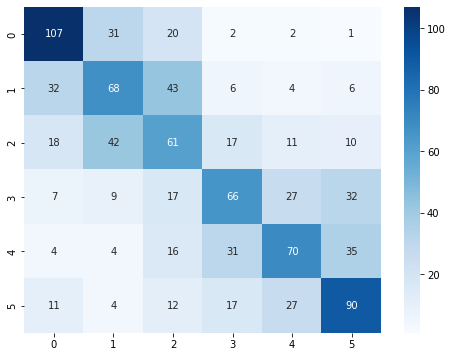

In [30]:
#Logistic Regression
pipe = LogisticRegression(max_iter=10_000,
                          penalty='l2',
                          solver='lbfgs')

pipe.fit(X_train_vec_pca , y_train)

pred_lr = pipe.predict(X_test_vec_pca)
evaluate(y_test, pred_lr)

#
score, matrix = get_score(y_test, pred_lr, "Logisitc Regression")
result.append(score)


plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_lr)), annot=True, cmap=plt.cm.Blues, fmt='.4g')





#Wrongly Predicted Sentences#

In [ ]:
# sentences that are missclassified ? 
misc_sent = np.array(X_test)
test_array = np.array(y_test)
pred_array = np.array(pred_lr)
wrong_pred = list()
for i in range(0, 100):
  if pred_array[i] != test_array[i]:
     wrong_pred.append([misc_sent[i], test_array[i], pred_array[i]])
wrong_pred[:5]


[["C'est en décembre 1967, après bien des invectives au Parlement, que sa loi relative à la régulation des naissances, dite loi Neuwirth est votée : elle autorise la vente exclusive des contraceptifs en pharmacie sur ordonnance médicale, avec autorisation parentale pour les mineures",
  'C1',
  'C2'],
 ['Giscard va pourtant réussir à transformer ce revers en tremplin',
  'C1',
  'A2'],
 ["Un choix difficile mais important : le public français écoute souvent les professionnels de Cannes pour choisir le film qu'il va aller voir au cinéma.",
  'A2',
  'B1'],
 ["Le débat porte plutôt sur l'utilité d'une telle mesure.", 'B1', 'B2'],
 ["Il faut du temps et du courage pour soigner toute cette ménagerie En plus des animaux, il faut aussi s'occuper du potager de mon papy",
  'A2',
  'B1']]

In [ ]:
#Misclassified sentences count 
Count = len(wrong_pred)

Count

51

#2- KNN 
    (Without data cleaning)

In [ ]:

#KNN 

pipe_k = KNeighborsClassifier()

pipe_k.fit(X_train_vec_pca, y_train)
pred_k = pipe_k.predict(X_test_vec_pca)
evaluate(y_test, pred_k)

## result : 0.3187
# improvement : 0.3542


#Improve : The best param has been choosed by hand since 

knn_grid = {'n_neighbors' : np.arange(1,500,5),
            'p': np.arange(1,3),
            'weights' : ['uniform', 'distance']}

KNN = KNeighborsClassifier()
pipe_k = GridSearchCV(KNN, knn_grid, cv = 5)


pipe_k.fit(X_train_vec_pca, y_train)
#print('Best hyperparameters:', KNN_CV.best_params_)
pred_k = pipe_k.predict(X_test_vec_pca)
evaluate(y_test, pred_k)

#
score, matrix = get_score(y_test, pred_k, "KNN Model")
result.append(score)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_k)), annot=True, cmap = "OrRd_r", fmt='.4g')





/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binar

CONFUSION MATRIX:
[[131  17   1  14   0   0]
 [105  31   3  20   0   0]
 [105  27   2  25   0   0]
 [ 75  24   1  57   0   1]
 [ 68  21   0  71   0   0]
 [ 80  20   0  60   0   1]]
ACCURACY SCORE:
0.2313
CLASSIFICATION REPORT:
	Precision: 0.2450
	Recall: 0.2297
	F1_Score: 0.1476


#3- Decision Tree
    (Without data cleaning)

CONFUSION MATRIX:
[[83 32 26 12  3  5]
 [50 51 34 20  4  5]
 [28 40 35 25 16 16]
 [ 9 17 35 38 25 20]
 [11 21 34 34 40 33]
 [15 14 26 33 34 36]]
ACCURACY SCORE:
0.2948
CLASSIFICATION REPORT:
	Precision: 0.2958
	Recall: 0.2947
	F1_Score: 0.2915
Accuracy:
0.2947916666666667


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


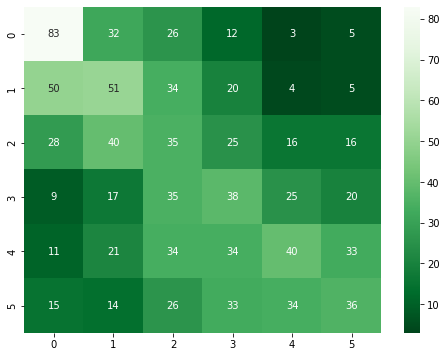

In [ ]:
#Decision tree


pipe_dt = DecisionTreeClassifier()
pipe_dt.fit(X_train_vec_pca, y_train)

pred_dt = pipe_dt.predict(X_test_vec_pca)
evaluate(y_test, pred_dt)

#
score, matrix = get_score(y_test, pred_dt, "Decision Tree")
result.append(score)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_dt)), annot=True, cmap = "Greens_r", fmt='.4g')


Hyperparameters: {'max_depth': 355}
CONFUSION MATRIX:
[[83 36 25  9  3  5]
 [50 58 31 14  3  8]
 [29 43 39 19 18 12]
 [11 18 31 40 23 21]
 [13 18 32 38 35 37]
 [13 12 30 29 36 38]]
ACCURACY SCORE:
0.3052
CLASSIFICATION REPORT:
	Precision: 0.3029
	Recall: 0.3056
	F1_Score: 0.3006
Accuracy:
0.30520833333333336


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


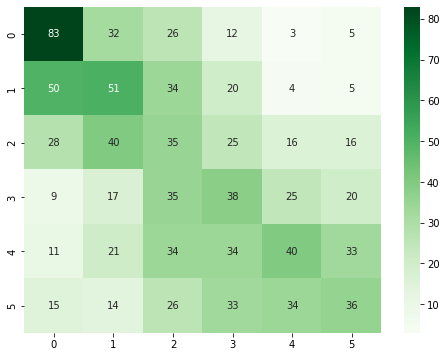

In [ ]:
# Decision tree Improvement
grid_tree = {'max_depth': np.arange(5,1000, 50)}

dec_tree = DecisionTreeClassifier()
pipe_dt2 = GridSearchCV(dec_tree, grid_tree, cv = 5)


pipe_dt2.fit(X_train_vec_pca, y_train)
pred = pipe_dt2.predict(X_test_vec_pca)
print("Hyperparameters:", dec_tree_CV.best_params_)
evaluate(y_test, pred)
#
score, matrix = get_score(y_test, pred, "Decision tree Improvement")
result.append(score)
# Plot
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_dt)), annot=True, cmap = "Greens", fmt='.4g')

#Without pca : ACCURACY SCORE:
#0.3052


# 4- Random Forest
    (Without data cleaning)

CONFUSION MATRIX:
[[118  21  15   6   1   0]
 [ 75  53  24   9   2   1]
 [ 37  38  44  26   8   7]
 [ 18  10  17  69  17  13]
 [ 16   6  22  55  50  24]
 [ 16  11  14  31  27  59]]
ACCURACY SCORE:
0.4094
CLASSIFICATION REPORT:
	Precision: 0.4203
	Recall: 0.4121
	F1_Score: 0.3997
Accuracy:
0.409375


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


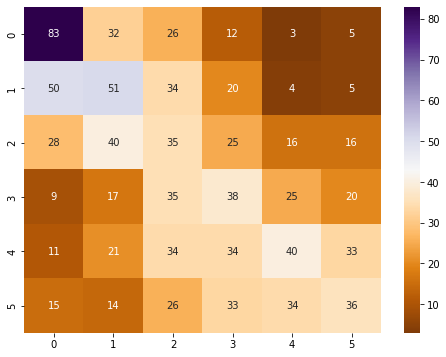

In [ ]:
# Random Forest 

pipe_rf = RandomForestClassifier()
pipe_rf.fit(X_train_vec_pca, y_train)
pred_rf = pipe_rf.predict(X_test_vec_pca)
evaluate(y_test, pred_rf)

#
score, matrix = get_score(y_test, pred_rf, "Random Forest")
result.append(score)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_dt)), annot=True, cmap = "PuOr", fmt='.4g')


In [ ]:
results = pd.DataFrame(result, columns=["Model", "Precision", "Recall", "F1- score", "Accuracy"])
results=results.set_index('Model')
results.head()

,Precision,Recall,F1- score,Accuracy
Model,,,,
Logisitc Regression,0.475666,0.479224,0.474447,0.478125
Random Forest,0.416684,0.416253,0.401491,0.413542
Decision tree Improvement,0.314862,0.315516,0.311864,0.315625
Decision Tree,0.301306,0.300758,0.298111,0.301042
KNN Model,0.419700,0.354327,0.345031,0.354167


# _______________________________________ #

# _______________________________________ #

#Model with data Cleaning
-------------------------------------

----------------

##Data Cleaning Process :##

1. Remove Punctuation
2. Tokenization
3. Remove Stopwords
4. Stemming / Lemmatization
5. Vectorization

In [ ]:
# Split Data
corpus_c = df_1['sentence'].tolist()

X_train, X_test, y_train, y_test = train_test_split(corpus_c, df_1['difficulty'].tolist(),
                                                    test_size = 0.2,
                                                    random_state = 0)


In [ ]:
# Tfidf Vectorizer 
vectorizer_c = TfidfVectorizer(tokenizer=cleaning, 
                               ngram_range=(1, 6),
                               analyzer='char',
                               min_df=2,
                               max_df=0.7,
                               norm='l2')

# 5- Logistic Regression#

    (With data cleaning)

CONFUSION MATRIX:
[[109  27  18   4   3   0]
 [ 55  72  29   5   2   1]
 [ 16  31  80  19   9   5]
 [  5   8   7  66  25  33]
 [  4   3  10  41  67  48]
 [  6   5   7  25  26  89]]
ACCURACY SCORE:
0.5031
CLASSIFICATION REPORT:
	Precision: 0.5013
	Recall: 0.5042
	F1_Score: 0.4996
Accuracy:
0.503125


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


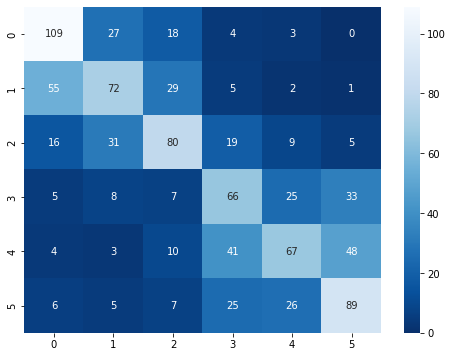

In [ ]:
# Logistic Regression

pipe_lrc = LogisticRegression(random_state=0, solver='lbfgs', max_iter=300)
pipe_lrc.fit(X_train_vec_pca, y_train)

pred_lr2 = pipe_lrc.predict(X_test_vec_pca)

LR_result = evaluate(y_test, pred_lr2)

#
score_c, matrix = get_score(y_test, pred_lr2, "Logisitc Regression")
result_c.append(score_c)

#plot map
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_lr2)), annot=True, cmap="Blues_r", fmt='.4g')


# 6- KNN with the best parameters #

    (With data cleaning)

CONFUSION MATRIX:
[[102  40  18   0   1   0]
 [ 67  67  20   3   2   5]
 [ 48  37  45   4   8  18]
 [ 14   6  10  40  11  63]
 [  9   4   8  23  36  93]
 [  6   8   5  12  14 113]]
ACCURACY SCORE:
0.4198
CLASSIFICATION REPORT:
	Precision: 0.4379
	Recall: 0.4207
	F1_Score: 0.4001
Accuracy:
0.4197916666666667


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


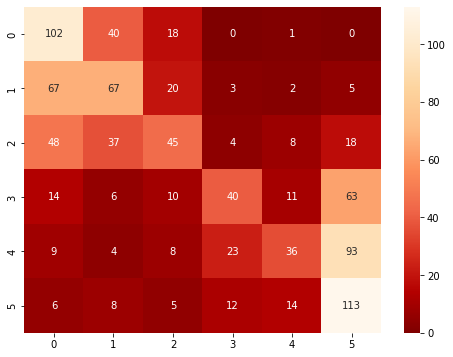

In [ ]:
#KNN 

# Pipe with best param
pipe_knn4 = KNeighborsClassifier(n_neighbors=14, p=2, weights='distance')

pipe_knn4.fit(X_train_vec_pca, y_train)


KNN_pred2 = pipe_knn4.predict(X_test_vec_pca)
evaluate(y_test, KNN_pred2)

#
score_c, matrix = get_score(y_test, KNN_pred2, "KNN Model")
result_c.append(score_c)

#plot
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, KNN_pred2)), annot=True, cmap="OrRd_r", fmt='.4g')


#7- Decision Tree 
    (With data cleaning)

CONFUSION MATRIX:
[[79 40 25  6  6  5]
 [43 58 33 14  8  8]
 [27 35 36 26 22 14]
 [ 6 18 20 34 34 32]
 [ 9 11 27 30 61 35]
 [ 8 16 18 29 41 46]]
ACCURACY SCORE:
0.3271
CLASSIFICATION REPORT:
	Precision: 0.3232
	Recall: 0.3249
	F1_Score: 0.3237
Accuracy:
0.32708333333333334


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


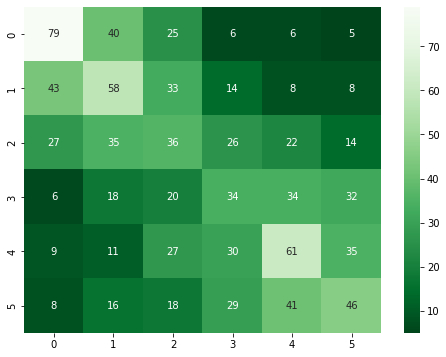

In [ ]:
#Decision Tree

pipe_dt_c =DecisionTreeClassifier()
pipe_dt_c.fit(X_train_vec_pca, y_train)

pred_dt2 = pipe_dt_c.predict(X_test_vec_pca)
evaluate(y_test, pred_dt2)

#
score_c, matrix = get_score(y_test, pred_dt2, "Decision Tree")
result_c.append(score_c)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_dt2)), annot=True, cmap = "Greens_r", fmt='.4g')


#8- Random Forest
    (With data cleaning)

CONFUSION MATRIX:
[[122  21  11   4   0   3]
 [ 74  51  27  10   1   1]
 [ 22  45  59  20   9   5]
 [  9  18  10  46  31  30]
 [ 12   4  13  50  55  39]
 [ 10   6  15  29  29  69]]
ACCURACY SCORE:
0.4188
CLASSIFICATION REPORT:
	Precision: 0.4129
	Recall: 0.4186
	F1_Score: 0.4084
Accuracy:
0.41875


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1370: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


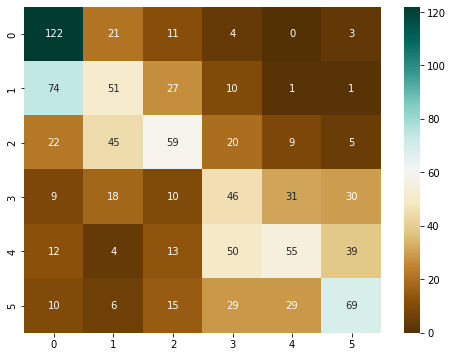

In [ ]:
#Random Forest

random_forest_classifier = RandomForestClassifier()
pipe_rf2 = Pipeline([('tfidf', vectorizer_c), ('random_forest_clf', random_forest_classifier)])
pipe_rf2.fit(X_train_vec_pca, y_train)
pred_rf2 = pipe_rf2.predict(X_test_vec_pca)
evaluate(y_test, pred_rf2)

#
score_c, matrix = get_score(y_test, pred_rf2, "Random Forest")
result_c.append(score_c)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, pred_rf2)), annot=True, cmap = "BrBG", fmt='.4g')


In [ ]:
# Results table of all used models
 
results = pd.DataFrame(result_c, columns=["Model", "Precision", "Recall", "F1- score", "Accuracy"])
results=results.set_index('Model')
results.head()

,Precision,Recall,F1- score,Accuracy
Model,,,,
Logisitc Regression,0.501281,0.504158,0.499639,0.503125
KNN Model,0.437922,0.420731,0.400117,0.419792
Decision Tree,0.323231,0.324866,0.323665,0.327083
Random Forest,0.412903,0.418594,0.408406,0.418750


#Kaggle submission#

In [ ]:
# create the dataframe as asked

# We choose to predict the unlabelled data with the logistic regression model seems to be the one giving the best accuracy 
submission_sentence =df_pred['sentence']

prediction = pipe_lrc.predict(submission_sentence)
print(prediction)
#
decoded = oe.inverse_transform(pd.DataFrame(prediction))
#
decoded
#
decoded_df=pd.DataFrame(decoded, columns = ['difficulty'])
decoded_df

#
submission_df = pd.concat([df_pred,decoded_df],  axis=1)

submission_df= submission_df.drop('sentence',axis=1)

submission_df.to_csv('Lausanne_submission.csv', index=False)
!cp Lausanne_submission.csv "drive/My Drive/"





     

### So far, Logistic regression is the model giving the best performance whit or without cleaning

# Improving Model Approach #

    Approches :
      1- Camembert
      2- PCA
      3- Keras 
      4- SVM